In [1]:
import numpy as np
from obspy import read
from obspy.io.xseed import Parser
from scipy import signal
import obspy
import matplotlib.pyplot as plt
from IPython.display import Image

## Loading Data and decimate it to 25Hz by factor 2

In [261]:
## Depends on workstation 
## day 337 in 2016 is  December 2, 2016 (Fri)
#st = read('../../TEST_DATA/DATA/KNR01/BHZ.D/1B.KNR01..BHZ.D.2016.337')
st = read('/data/cen/u254/Essing/AWI/KNIPA_NEW/2016/1B/KNR01/BDH.D/1B.KNR01..BDH.D.2016.317')
#parser01 = Parser('../../TEST_DATA/Resp/RESP.1B.KNR01..BHZ')
#parser01 = Parser('/data/cen/u254/Essing/AWI/CAL/RESP.1B.KNR01..BDH')
st = st.decimate(factor=2)
st_simu = st.copy()
#st_simu.simulate(seedresp={'filename': parser01, 'units': "ACC"})
st_simu_filt = st_simu.copy()
st_simu_filt = st_simu_filt.filter('bandpass',freqmin=2, freqmax=4.9)

fs = int(st_simu[0].stats.sampling_rate)

In [262]:
figname = str(st[0].stats.station) + st[0].stats.channel #+ st[0].stats.starttime)

print(((str(st[0].stats.station), st[0].stats.channel,st[0].stats.starttime)))

('KNR01', 'BDH', UTCDateTime(2016, 11, 11, 23, 59, 59, 960000))


# Filtercorner testing

In [ ]:
st_filt = st.copy()
st_filt = st_filt.filter('bandpass',freqmin=1, freqmax=8)
st_array = np.asarray(st[0].data)
st_filt_array = np.asarray(st_filt[0].data)

fs = int(st_filt[0].stats.sampling_rate)

t_start = fs*20000
t1_start = t_start+fs*8000
st_nofilt_10_min = st_array[t_start:t_start+10*fs*60]
st_filt_10_min = st_filt_array[t_start:t_start+10*fs*60]
#test1_10_min = st_array[t1_start:t1_start+10*fs*60]

In [ ]:
f, Pxx = signal.periodogram(st_nofilt_10_min, fs=fs)
f1,Pxx1 = signal.periodogram(st_filt_10_min, fs=fs)

In [ ]:
#plt.semilogy(f, Pxx)
plt.subplot(121)
plt.plot(f, Pxx,label='nofilt')
#plt.xlim(0,5)
#plt.ylim(1e-4,1e6)
plt.grid()

plt.subplot(122)
plt.plot(f1, Pxx1,label='filt')
#plt.xlim(0,1)
#plt.ylim(1e-4,1e6)
plt.grid()

plt.show()

# Remove response

In [ ]:
parser01 = Parser('../TEST_DATA/Resp/RESP.1B.KNR01..BHZ')
st_simu = st.copy()
st_simu.simulate(seedresp={'filename': parser01, 'units': "ACC"})

In [ ]:
st_simu_filt = st_simu.copy()
st_simu_array = np.array(st_simu[0].data)

st_simu_filt = st_simu_filt.filter('highpass',freq=1)
st_simu_filt_array = np.array(st_simu_filt[0].data)

In [ ]:
plt.plot(st_simu_filt_array)
#plt.xlim(318800,319500)
plt.show()

In [ ]:
t_start = fs*20000
t1_start = t_start+fs*30000

st_simu_nofilt_10_min = st_simu_array[t_start:t_start+10*fs*60]
st_simu_filt_10_min = st_simu_filt_array[t_start:t_start+10*fs*60]

In [ ]:
f2, Pxx2 = signal.periodogram(st_simu_nofilt_10_min, fs=fs)
f3, Pxx3 = signal.periodogram(st_simu_filt_10_min, fs=fs)

In [ ]:
plt.figure(figsize=(11,11))
#plt.semilogy(f, Pxx)
plt.subplot(221)
plt.plot(f, Pxx,label='nofilt')
#plt.xlim(0,5)
#plt.ylim(1e-4,1e6)
plt.legend()
plt.grid()

plt.subplot(222)
plt.plot(f1, Pxx1,label='filt')
#plt.xlim(0,1)
#plt.ylim(1e-4,1e6)
plt.legend()
plt.grid()

#plt.semilogy(f, Pxx)
plt.subplot(223)
plt.plot(f2, Pxx2, label='st_simu_nofilt')
#plt.xlim(0,1)
#plt.ylim(1e-4,1e6)
plt.legend()
plt.grid()

plt.subplot(224)
plt.plot(f3, Pxx3, label='st_simu_filt')
#plt.xlim(0,1)
#plt.ylim(1e-4,1e6)
plt.legend()
plt.grid()

plt.show()

# Signal vs. no signal

In [ ]:
st_simu.plot()

In [ ]:
#t_signal_start = 20000*fs
#t_nosignal_start = 28000*fs
#win_len = 4*60*fs

st_simu_array = np.array(st_simu_filt[0].data)

In [ ]:
st_simu_array1 = np.append(st_simu_array, 0)

In [ ]:
st_simu_signal_1_min = st_simu_array[t_signal_start:t_signal_start+win_len]
f_sig, Pxx_sig = signal.periodogram(st_simu_signal_1_min, fs=fs)

In [ ]:
Image('KNR01.BHZ_2016-12-02T00:00:00.000000Z.png')

In [ ]:
plt.plot(f_sig, Pxx_sig)
plt.plot(f_sig[np.argmax(Pxx_sig)], np.max(Pxx_sig), '.')
#plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
plt.show()

In [ ]:
def search_maxima_in_periodogram(maxima, data, fs=fs, wlen):
    
    '''Function to cut daily data into several windows and searche for maxima in each window
    Input:
    
    maxima    float        number of maxima to search for
    signal    array        array with data
    fs        float        value of sampling rate
    wlen      int          value of window length in seconds
    
    '''

    
    
    
    
    f_sig, Pxx_sig = signal.periodogram(data, fs=fs)
    index_max = np.zeros(maxima)
    value_max_f = np.zeros(maxima)
    value_max = np.zeros(maxima)
    Pxx_sig1 = Pxx_sig.copy()
    
    #wlen = wlen * fs
    #st_simu_signal_1_min = st_simu_array[t_signal_start:t_signal_start+win_len]
    #for wlen in data:
        #data_cut = st_simu_array[t_signal_start:t_signal_start+win_len]
        #print(data_cut)
    for i in range(maxima):

        # first maxima


        index_max[i] = np.argmax(Pxx_sig1)
        value_max_f[i] = f_sig[np.argmax(Pxx_sig1)]
        value_max[i] = np.max(Pxx_sig1)

        minval = np.min(Pxx_sig1)
        Pxx_sig1[int(index_max[i]-10):int(index_max[i]+10)] = minval-100
    #fname = '../Plots/PSD/KNR01..BHZ.D.2016.337' + str(t_signal_start) + '-' + str(t_signal_start+ win_len)
    #plt.semilogy(f_sig, Pxx_sig)
    #plt.semilogy(value_max_f, value_max, 'o')
    #plt.plot(value_ond_max_f, value_second_max, 'o')
    #plt.plot(value_third_max_f, value_third_max, 'o')
    #plt.plot(value_fourth_max_f, value_fourth_max, 'o')
    #plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
    #plt.savefig(fname=fname)
    return(value_max_f, value_max)

In [ ]:
maxima = 8
data= st_simu_signal_1_min

value_max_f, value_max = search_maxima_in_periodogram(maxima, data, fs=fs)

In [ ]:
plt.plot(f_sig, Pxx_sig)
plt.plot(value_max_f, value_max, 'o')
plt.ylim(0*1e-10,6*1e-10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
#plt.xlim(1.2,2)
plt.grid()
#plt.plot(value_ond_max_f, value_second_max, 'o')
#plt.plot(value_third_max_f, value_third_max, 'o')
#plt.plot(value_fourth_max_f, value_fourth_max, 'o')
#plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
plt.show()



# next steps...
# 1) while schleife mit abbruchkriterium nach 4-6 Durchlaeufen
# 2) als definition schreiben
# 3) 

# mlab.specgram

In [263]:
from matplotlib import mlab, transforms
plt.rcParams['image.cmap'] = 'Oranges'
import math as M

In [264]:
def _nearest_pow_2(x):
    """
    Find power of two nearest to x
    >>> _nearest_pow_2(3)
    2.0
    >>> _nearest_pow_2(15)
    16.0
    :type x: float
    :param x: Number
    :rtype: Int
    :return: Nearest power of 2 to x
    """
    a = M.pow(2, M.ceil(np.log2(x)))
    b = M.pow(2, M.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b

In [265]:
data = np.array(st_simu_filt[0].data)
data = data - data.mean()
per_lap = .1
wlen = float(fs*10)
npts = len(data)
nfft = int(_nearest_pow_2(wlen * fs))
nlap = int(nfft * float(per_lap))

In [266]:
def searchmaxima(maxima, data, distance, scale_vector=0):
    
    '''
    To find maxima in data, with option to give vecotr with scaling values for x-Axis
    
    Input:
    maxima    scalar        value of maxima to find
    data      1-D array     numpy array of data 
    distance  scalar        value for nearest next maxima to search for
    freqvec   1-D array     numpy array of data with values to scale x-Axis (optional)
    
    '''

    index_max = np.zeros(maxima)
    value_max_f = np.zeros(maxima)
    value_max = np.zeros(maxima)
    data1 = data.copy()
    
    if type(scale_vector) == int:
    
        for i in range(maxima):
            index_max[i] = np.argmax((data1))
            value_max[i] = np.max((data1))
            #index_max[i] = np.argmax(Pxx_sig1)
            #value_max_f[i] = freqvec[np.argmax(data1)]
            #value_max[i] = np.max(Pxx_sig1)

            minimal_value = np.min(data1)

            data1[int(index_max[i]-15):int(index_max[i]+15)] = minimal_value-100
        return(value_max, index_max)
    
    else:
        for i in range(maxima):
            index_max[i] = np.argmax((data1))
            value_max[i] = np.max((data1))
            value_max_f[i] = scale_vector[np.argmax(data1)]
            minimal_value = np.min(data1)
        
            data1[int(index_max[i]-distance):int(index_max[i]+distance)] = minimal_value-100
            
        return(value_max, index_max,value_max_f)

In [267]:
specgram, freq, time = mlab.specgram(data, Fs=fs, NFFT=nfft, noverlap=0)

max_array = np.zeros_like(specgram)
threshold = np.amax(specgram)*5e-4
freq_minimal_value = 2
#all_win_average = np.mean(specgram.T)


for j in range(np.shape(specgram)[1]):
    win_average = np.mean(specgram.T[j])
    #if win_average < all_win_average:
    # not a good solution. deletes as well some instrument signal

    amp_value, frequency_index, frequency_value = searchmaxima(maxima=10, data=specgram.T[j],distance=120, scale_vector=freq)


    if any(frequency_value<freq_minimal_value) == True:
        for i in range(len(frequency_index)):


            if amp_value[i] > threshold:
                max_array[int(frequency_index[i]),j] = amp_value[i]

        

/home/zmaw/u300967/.conda/envs/vgseis_2018/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


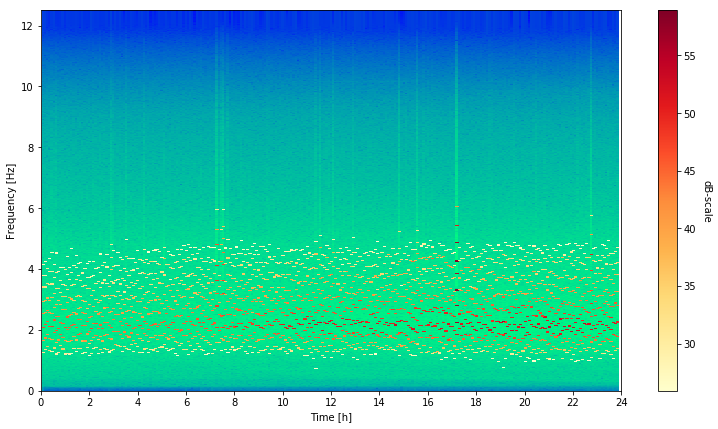

In [268]:
fig, ax = plt.subplots(figsize=(13,7))
specgram_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(specgram[1:,:]), alpha=1, cmap='winter')
amp_val_plot = ax.pcolormesh(time/3600, freq, 10 * np.log10(max_array),cmap='YlOrRd')
#specgram_plot = ax.pcolormesh(10 * np.log10(specgram[1:,:]), alpha=1, cmap='winter')
#amp_val_plot = ax.pcolormesh(10 * np.log10(max_array), alpha=.5, cmap='YlOrRd')
cbar = plt.colorbar(amp_val_plot)

cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('dB-scale', rotation=270)

plt.xticks(np.linspace(0,24,13))
#plt.xlim(14,20)
#plt.ylim(0,6)
#plt.grid(alpha=.1)

plt.xlabel('Time [h]')
plt.ylabel('Frequency [Hz]')
plt.show()

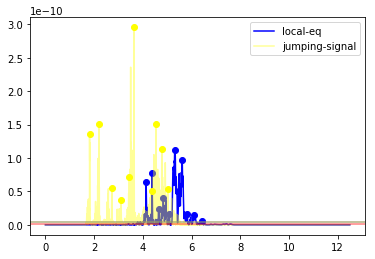

In [167]:
value_max, _, value_max_f = searchmaxima(maxima=10, data=specgram.T[175], distance=50, scale_vector=freq)
value_max1, _, value_max_f1 = searchmaxima(maxima=10, data=specgram.T[79], distance=50, scale_vector=freq)



#plt.plot(freq,specgram.T[17], label='eq')
#plt.plot(freq,specgram.T[33], label='eq')
plt.plot(freq,specgram.T[79], color='blue', label='local-eq')
plt.plot(value_max_f1, value_max1, 'o', color='blue')
plt.plot(freq,specgram.T[175], color='yellow', label='jumping-signal', alpha=.4)
plt.plot(value_max_f, value_max, 'o', color='yellow')
#plt.plot(freq,specgram.T[40], color='green', label='signal')
#plt.plot(value_max_f1, value_max1, 'o', color='green')
#plt.axhline(np.mean(specgram.T[117]), xmin=0, xmax=50, color='red', alpha=.5)
#plt.plot(freq, specgram.T[41], label='good pick')#, transform=rot + base)
#plt.plot(freq,specgram.T[41], label='noeq')
plt.axhline(np.mean(specgram.T[79]), xmin=0, xmax=50, color='blue', alpha=.5)
plt.axhline(np.mean(specgram.T),  xmin=0, xmax=50, color='red', alpha=.5)
plt.axhline(np.mean(specgram.T[175]),  xmin=0, xmax=50, color='yellow', alpha=.5)
#plt.ylim(0,.25*1e-10)
#plt.plot(specgram.T[60], label='150')
plt.legend()
plt.show()

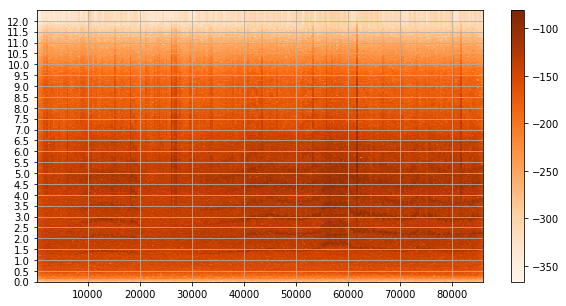

In [168]:
plt.figure(figsize=(10,5))
plt.pcolormesh(time, freq, 10 * np.log10(specgram[1:,:]))
#plt.pcolormesh( 10 * np.log10(max_array))
plt.grid()
plt.yticks(np.linspace(0,12,25))
#plt.xlim(10000,30000)
#plt.ylim(1,2)
plt.colorbar()
plt.show()

In [ ]:
500*12.5/4096

In [30]:
testarray = np.zeros((np.shape(specgram)[1]))
for i in range(np.shape(specgram)[1]):
    testarray[i] = np.sum(specgram.T[i])
    
print(np.mean(testarray))

8.545331132805633e-09


In [ ]:
plt.plot(testarray)
plt.plot(0,np.mean(testarray), 'o')
plt.show()

In [ ]:
amp_value, no_samp, freqs= searchmaxima(maxima=3, data=specgram.T[100], scale_vector=freq)

In [ ]:
plt.plot(63, no_samp[0], 'o')
plt.show()
print(np.shape(specgram))

In [ ]:
plt.figure(figsize=(12,8))
for i in range(63,64):
    value_max, _,value_max_f = searchmaxima(maxima=10, data=specgram.T[i], scale_vector=freq)
    plt.plot(freq,specgram.T[i], alpha=.3)
    plt.scatter(value_max_f, value_max, s=value_max*1e12, color='tomato')
    plt.grid(alpha=.3)
    plt.xlim(0,8)
    plt.xticks(np.linspace(0,8,17))
    plt.xlabel('Frequency [Hz]')
    print(i)
plt.show()

In [ ]:
print(value_max*1e10)

In [ ]:
plt.figure(figsize=(12,8))
for i in range(np.shape(specgram.T)[0]):
    value_max, _,value_max_f = searchmaxima(maxima=10, data=specgram.T[i], scale_vector=freq)
    plt.plot(freq,specgram.T[i], alpha=.1)
    plt.scatter(value_max_f, value_max, s=value_max*1e12, color='tomato')
    plt.ylim(0,1.5e-9)
    plt.xlim(0,8)
    plt.xticks(np.linspace(0,8,17))
    plt.xlabel('Frequency [Hz]')
    
    if i%5 == 0:
        plt.savefig('../../Plots/test1/'+ str(i))
        plt.clf()
#plt.show()

In [ ]:
plt.plot(specgram[948])
plt.plot((value_max_f), (value_max), 'o')
#plt.ylim(0*1e-10,6*1e-10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
#plt.xlim(1.2,2)
plt.grid()
#plt.plot(value_ond_max_f, value_second_max, 'o')
#plt.plot(value_third_max_f, value_third_max, 'o')
#plt.plot(value_fourth_max_f, value_fourth_max, 'o')
#plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
plt.show()



In [ ]:
test = np.linspace(20,30,11)

In [ ]:
print(test.mean())

In [ ]:
24*3600

In [ ]:
a = np.linspace(0,9,10)
b = np.linspace(0,2,3)
c = np.ones((len(a), len(b)))

In [ ]:
for i in range(len(a)):
    for j in range(len(b)):
        c[i,j] *= np.random.rand()

In [ ]:
print(c)

In [ ]:
plt.pcolormesh(c)
plt.colorbar()
plt.show()

In [ ]:
print(c.T[0])

In [ ]:
20000*264/86400

In [ ]:
print(len(freq))